In [1]:
# Data processing
import numpy as np
import pandas as pd
import datetime as dt

# Download data
import yfinance as yf

from scipy.stats import norm
import statsmodels.api as sm
from matplotlib import pyplot as plt

In [2]:
# Initial investment and currency per stock

# in dollar values initially?

principle = 100000000 #100mil

# initial weights

# for respective instruments, and 10% for cash
weights = np.array([0.1,0.2,0.2,0.2,0.2, 0.1])

investment = {
    "DBA" : [10000000, 'USD'], # iPath Pure Beta Broad Commodity ETN (BCM)
    "EWQ" : [20000000, 'USD'], # iShares MSCI France ETF, NYSE, USD
    "^AEX"  : [20000000, 'EUR'], # AEX Index
    "^GSPC" : [20000000, 'USD'], # S&P 500 Index
    "^N225" : [20000000, 'JPY'] # Nikkei 225
}

start = "2010-01-01"
end = "2018-12-31"

In [3]:
# Download data and store in dataframe

instruments_data = yf.download(' '.join(list(investment.keys())), start=start, end=end, groupby='ticker')
instruments = instruments_data['Adj Close']

[*********************100%***********************]  5 of 5 completed


In [4]:
# Create exchange rate ticker list based on initial investment data
currencies = list(set(['EUR' + i[1] + '=X' for i in investment.values()]))

# Remove EUR-EUR exchange rate
for currency in currencies:
    if currency[0:2] == currency[3:5]:
        currencies.remove(currency)
        
currencies = " ".join(currencies)

In [5]:
# Download exchange rate data
exchangerate_data = yf.download(currencies, start=start, end=end, groupby='ticker')
exchangerate = exchangerate_data['Adj Close']
exchangerate.tail()

[*********************100%***********************]  2 of 2 completed


,EURJPY=X,EURUSD=X
Date,,
2018-12-24,126.292000,1.137281
2018-12-25,125.769997,1.140394
2018-12-26,126.001999,1.141553
2018-12-27,126.404999,1.136131
2018-12-28,126.767998,1.143105


In [6]:
# invest in Euribor 3m future, exposure to interest rates

euribor3m_future = pd.read_excel('data/euribor_FEU300-EUR.xlsx')
euribor3m = euribor3m_future['Last']


In [7]:
# Make index datetime
euribor3m.index = pd.to_datetime(euribor3m_future.Date)

In [8]:
euribor3m = euribor3m.iloc[::-1]
euribor3m = euribor3m[start:end]

In [9]:
# invest in stock (and commodity) indices (by investing in mutual funds)? ETFs?


instruments

,DBA,EWQ,^AEX,^GSPC,^N225
Date,,,,,
2009-12-31,25.755527,19.757006,NaN,1115.099976,NaN
2010-01-04,25.999054,20.460157,343.029999,1132.989990,10654.790039
2010-01-05,26.164654,20.406656,342.019989,1136.520020,10681.830078
2010-01-06,26.310770,20.513659,341.480011,1137.140015,10731.450195
2010-01-07,26.106207,20.421942,340.549988,1141.689941,10681.660156
...,...,...,...,...,...
2018-12-24,16.687899,24.885502,478.339996,2351.100098,NaN
2018-12-25,NaN,NaN,NaN,NaN,19155.740234
2018-12-26,16.697742,25.567028,NaN,2467.699951,19327.060547


### Step2: 
Implement and backtest VaR and ES for the two abovementioned confidence levels and 1-day horizon using the following methods:

In [10]:
from functools import reduce

In [11]:
# merge the instrument prices, exchange rates, and euribor into one dataframe
dfs = [instruments, exchangerate, euribor3m]
df_pf = reduce(lambda left,right: pd.merge(left,right,left_index=True, right_index=True), dfs)
df_pf = df_pf.rename(columns={5: 'euribor3m', '^AEX':'AEX', '^GSPC':'GSPC','^N225':'N225', 'Last':'euribor3m'})

In [12]:
instrument_names = list(df_pf.columns[:5])
instrument_names.append('euribor3m')

In [13]:
instrument_names

['DBA', 'EWQ', 'AEX', 'GSPC', 'N225', 'euribor3m']

In [14]:
df_returns_all = np.log(df_pf[instrument_names])- np.log(df_pf[instrument_names].shift())

df_returns_all['euribor3m'] = np.log(df_pf['euribor3m'])- np.log(df_pf['euribor3m'].shift()) # negative rates?

# calculate the FX returns, and use them to adjust the foreign currency denominated indices
df_returns_all['EURJPY_ret'] = np.log(df_pf['EURJPY=X'])- np.log(df_pf['EURJPY=X'].shift())
df_returns_all['EURUSD_ret'] = np.log(df_pf['EURUSD=X'])- np.log(df_pf['EURUSD=X'].shift())

In [15]:
df_returns_all.head()

,DBA,EWQ,AEX,GSPC,N225,euribor3m,EURJPY_ret,EURUSD_ret
Date,,,,,,,,
2010-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,0.006349,-0.002618,-0.002949,0.003111,0.002535,0.000151,-0.014042,-0.004031
2010-01-06,0.005569,0.005230,-0.001580,0.000545,0.004635,0.000101,0.011212,0.002647
2010-01-07,-0.007805,-0.004481,-0.002727,0.003993,-0.004650,0.000151,0.005511,-0.005989
2010-01-08,0.002981,0.013752,0.004073,0.002878,0.010862,-0.000050,-0.001931,0.006478


In [16]:
# select the estimation period
df_returns = df_returns_all[instrument_names][:]

In [17]:
# adjust for exchange rates
df_returns['DBA'] = df_returns['DBA'] * (1+df_returns_all['EURUSD_ret'])
df_returns['EWQ'] = df_returns['EWQ'] * (1+df_returns_all['EURUSD_ret'])
df_returns['GSPC'] = df_returns['GSPC'] * (1+df_returns_all['EURUSD_ret'])
df_returns['N225'] = df_returns['N225'] * (1+df_returns_all['EURJPY_ret'])

#### Estimate VaR and ES, based on Variance-Covariance method, multivariate normal distribution

In [18]:
# calculate the variance-covariance matrix
cov_matrix = df_returns.cov()
cov_matrix

,DBA,EWQ,AEX,GSPC,N225,euribor3m
DBA,6.680151e-05,4.054976e-05,2.084994e-05,2.341740e-05,1.201325e-05,-6.176495e-08
EWQ,4.054976e-05,2.212690e-04,1.102516e-04,1.165002e-04,3.237039e-05,-3.270876e-07
AEX,2.084994e-05,1.102516e-04,1.154280e-04,6.463286e-05,4.734517e-05,-9.876114e-08
GSPC,2.341740e-05,1.165002e-04,6.463286e-05,9.079651e-05,2.248005e-05,-1.309112e-07
N225,1.201325e-05,3.237039e-05,4.734517e-05,2.248005e-05,1.796203e-04,-1.540590e-07
euribor3m,-6.176495e-08,-3.270876e-07,-9.876114e-08,-1.309112e-07,-1.540590e-07,5.689059e-08


In [19]:
# calculate the mean return
avg_returns = df_returns.mean()

In [21]:
# calculate the portfolio mean
pf_mean_pct = sum(avg_returns*weights)
pf_mean_pct

0.00015997788952196355

In [22]:
# calculate the portfolio standard deviation in percentage terms
pf_std_pct = np.sqrt(weights.T.dot(cov_matrix).dot(weights))
pf_std_pct

0.00776421970328646

In [56]:
# convert the pf return and std from percentage to euro
pf_mean_euro = pf_mean_pct * principle
pf_std_euro = pf_std_pct * principle

print (pf_mean_euro)
print (pf_std_euro)

1125984210834.7756
776421.970328646


In [24]:
confidence_levels = [0.975, 0.99]
alphas = [0.025,0.01]
alphas

[0.025, 0.01]

In [25]:
# calculate the VaR
var_975_1d = norm.ppf(confidence_levels[0]) * pf_std_euro - pf_mean_euro
es_975_1d = alphas[0]**-1 * norm.pdf(norm.ppf(alphas[0]))*pf_std_euro - pf_mean_euro

In [26]:
var_990_1d = norm.ppf(confidence_levels[1]) * pf_std_euro - pf_mean_euro
es_990_1d = alphas[1]**-1 * norm.pdf(norm.ppf(alphas[1]))*pf_std_euro - pf_mean_euro

In [27]:
print(f'VaR 99% 1d: {var_990_1d}, ES 99% 1d: {es_990_1d}')

VaR 99% 1d: 1790229.8110804502, ES 99% 1d: 2053333.087356622


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


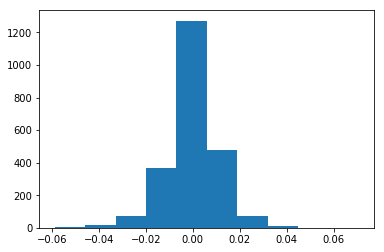

In [28]:
plt.hist(df_returns['AEX']);

#### Estimate VaR and ES, based on Variance-Covariance method, Student-t distribution with 3, 4, 5, 6 degrees of freedom

In [29]:
from scipy.stats import t

In [30]:
degree_of_freedom = [3,4,5,6]

In [31]:
# at 97.5% confidence level
for df in degree_of_freedom:
    
    tppf = t.ppf(alphas[0], df)
    
    var_975_1d_t= t.ppf(confidence_levels[0], df) * pf_std_euro - pf_mean_euro
    
    es_975_1d_t = -1/alphas[0] * (1-df)**(-1) * (df-2+tppf**2) * t.pdf(tppf, df)*pf_std_euro - pf_mean_euro
    
    
    print(f'Student-t distribution with {df} degree of freedom: \nVaR 97.5% 1d: {np.round(var_975_1d_t,3)}, ES 97.5% 1d: {np.round(es_975_1d_t,3)}\n')

Student-t distribution with 3 degree of freedom: 
VaR 97.5% 1d: 2454923.442, ES 97.5% 1d: 3300737.117

Student-t distribution with 4 degree of freedom: 
VaR 97.5% 1d: 2139695.19, ES 97.5% 1d: 2555047.384

Student-t distribution with 5 degree of freedom: 
VaR 97.5% 1d: 1979858.426, ES 97.5% 1d: 2247133.72

Student-t distribution with 6 degree of freedom: 
VaR 97.5% 1d: 1883838.33, ES 97.5% 1d: 2090347.913



In [32]:
# compare with VaR and ES under standard normal distribution
print(f'VaR 97.5% 1d: {np.round(var_975_1d,3)}, ES 97.5% 1d: {np.round(es_975_1d,3)}')

VaR 97.5% 1d: 1505761.31, ES 97.5% 1d: 1799123.661


In [33]:
# at 99% confidence level
for df in degree_of_freedom:
    
    tppf = t.ppf(alphas[1], df)
    
    var_990_1d_t= t.ppf(confidence_levels[1], df) * pf_std_euro - pf_mean_euro
    
    es_990_1d_t = -1/alphas[1] * (1-df)**(-1) * (df-2+tppf**2) * t.pdf(tppf, df) * pf_std_euro - pf_mean_euro
    
    
    print(f'Student-t distribution with {df} degree of freedom: \nVaR 97.5% 1d: {np.round(var_990_1d_t,3)}, ES 97.5% 1d: {np.round(es_990_1d_t,3)}\n')

Student-t distribution with 3 degree of freedom: 
VaR 97.5% 1d: 3509503.671, ES 97.5% 1d: 4960907.708

Student-t distribution with 4 degree of freedom: 
VaR 97.5% 1d: 2893214.485, ES 97.5% 1d: 3587992.354

Student-t distribution with 5 degree of freedom: 
VaR 97.5% 1d: 2596607.791, ES 97.5% 1d: 3017389.948

Student-t distribution with 6 degree of freedom: 
VaR 97.5% 1d: 2424039.005, ES 97.5% 1d: 2720529.681



In [34]:
# compare with VaR and ES under standard normal distribution
print(f'VaR 99% 1d: {np.round(var_990_1d,3)}, ES 99% 1d: {np.round(es_990_1d,3)}')

VaR 99% 1d: 1790229.811, ES 99% 1d: 2053333.087


#### Estimate VaR and ES, based on Historical Simulation method

In [35]:
# calculate the historical losses, and order them in increasing order
df_returns = df_returns[:] # select the simulation period
pf_losses = np.sort(principle * df_returns.dot(weights))

In [36]:
# at 97.5% confidence level
var_975_1d_hsm = pf_losses[int(alphas[0]*len(pf_losses))]
es_975_1d_hsm = pf_losses[0:int(alphas[0]*len(pf_losses))].mean()

In [37]:
print(f'VaR 97.5% 1d: {np.round(var_975_1d_hsm,3)}, ES 97.5% 1d: {np.round(es_975_1d_hsm,3)}')

VaR 97.5% 1d: -1605894.394, ES 97.5% 1d: -2332376.66


In [38]:
# at 99% confidence level
var_990_1d_hsm = pf_losses[int(alphas[1]*len(pf_losses))]
es_990_1d_hsm = pf_losses[0:int(alphas[1]*len(pf_losses))].mean()

In [39]:
print(f'VaR 99% 1d: {np.round(var_990_1d_hsm,3)}, ES 99% 1d: {np.round(es_990_1d_hsm,3)}')

VaR 99% 1d: -2314570.75, ES 99% 1d: -3059666.776


#### Estimate VaR and ES, based on Constant Conditional Correlation method

In [40]:
# Fill empty cells
df_returns = df_returns.ffill().iloc[1:,:]

# Rescale data to monetary values
returns = df_returns*principle

In [41]:
returns

,DBA,EWQ,AEX,GSPC,N225,euribor3m
Date,,,,,,
2010-01-05,632366.564782,-2.607765e+05,-2.948721e+05,3.098294e+05,2.499023e+05,15112.969475
2010-01-06,558369.483869,5.243641e+05,-1.580038e+05,5.468154e+04,4.686488e+05,10074.044234
2010-01-07,-775852.227522,-4.454200e+05,-2.727222e+05,3.969305e+05,-4.676061e+05,15109.163737
2010-01-08,299992.106109,1.384151e+06,4.073368e+05,2.896225e+05,1.084136e+06,-5036.134264
2010-01-11,-450521.134510,8.512906e+05,-4.161461e+05,1.757321e+05,1.084136e+06,15107.641978
...,...,...,...,...,...,...
2018-12-19,-174755.015541,-8.308029e+05,3.109687e+05,-1.555037e+06,-6.055141e+05,9971.083865
2018-12-20,-291666.102118,-4.175886e+05,-2.040885e+06,-1.591753e+06,-2.878131e+06,4985.169123
2018-12-21,-824977.975240,-1.346596e+06,-2.389840e+05,-2.092574e+06,-1.110547e+06,0.000000


In [42]:
# Divide train and test split
split_date = dt.datetime(2012,1,1)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 7838.396086456631
            Iterations: 5
            Function evaluations: 35
            Gradient evaluations: 5


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/arch/univariate/base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.208e+12. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 1e-05 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/arch/univariate/base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 4.978e+12. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 1e-05 * y.

This warning can be disabled by either rescaling y before initializing the
model

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 8164.620986523053
            Iterations: 6
            Function evaluations: 40
            Gradient evaluations: 6


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/arch/univariate/base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.815e+12. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 1e-05 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning


Optimization terminated successfully.    (Exit mode 0)
            Current function value: 7896.194011868129
            Iterations: 6
            Function evaluations: 41
            Gradient evaluations: 6


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/arch/univariate/base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.743e+12. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 1e-05 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning


Optimization terminated successfully.    (Exit mode 0)
            Current function value: 7866.450217496082
            Iterations: 6
            Function evaluations: 41
            Gradient evaluations: 6


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/arch/univariate/base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.019e+12. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 1e-05 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning


Optimization terminated successfully.    (Exit mode 0)
            Current function value: 7934.612493915942
            Iterations: 5
            Function evaluations: 34
            Gradient evaluations: 5


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/arch/univariate/base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.576e+09. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.001 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning


Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6124.9511064411345
            Iterations: 8
            Function evaluations: 55
            Gradient evaluations: 8


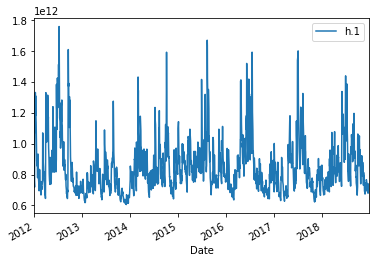

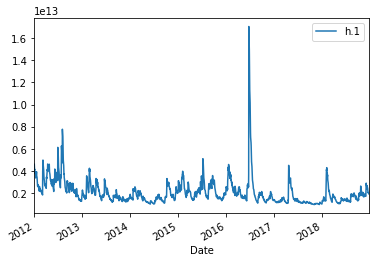

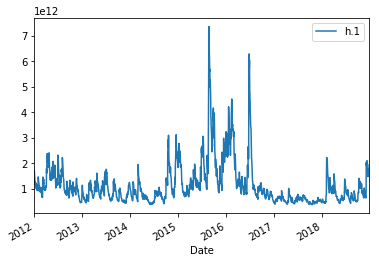

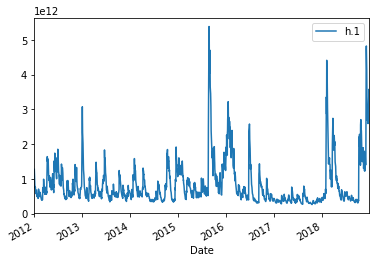

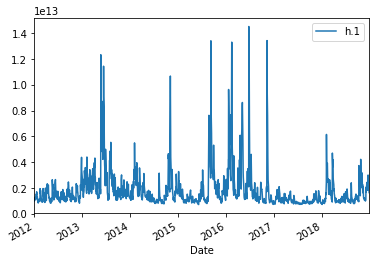

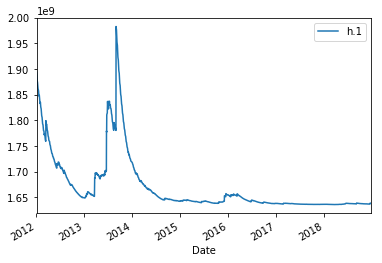

In [43]:
from arch import arch_model

# Create empty dict to store parameter values
params_dict = {}

# Create dataframe to store volatility forecasts
variance_forecast = pd.DataFrame(index=returns.loc[split_date:end].index)

# Fit GARCH(1,1) for each instrument
for instrument in returns.columns:

    garch11 = arch_model(returns[instrument], p=1, q=1, dist='Normal', vol='Garch')
    res = garch11.fit(update_freq=10, last_obs=split_date)
    
    forecasts = res.forecast(start=split_date, method='simulation')
    forecasts.variance[split_date:].plot();
    
    variance_forecast[instrument] = forecasts.variance[split_date:]
    params_dict[instrument] = res.params

In [44]:
# Forecasted volatilities by GARCH(1,1)
variance_forecast.head()

,DBA,EWQ,AEX,GSPC,N225,euribor3m
Date,,,,,,
2012-01-02,7.530999e+11,4.617377e+12,1.704722e+12,1.278602e+12,1.002512e+12,1.894334e+09
2012-01-03,7.338599e+11,4.212994e+12,1.537373e+12,1.150984e+12,1.013675e+12,1.889329e+09
2012-01-04,7.185168e+11,4.117874e+12,1.509900e+12,1.015540e+12,1.021569e+12,1.885749e+09
2012-01-05,1.190927e+12,4.161182e+12,1.425547e+12,9.102351e+11,1.035666e+12,1.883476e+09
2012-01-06,1.071600e+12,4.066542e+12,1.282711e+12,8.199715e+11,1.162685e+12,1.878908e+09


In [45]:
# Estimate constant correlation matrix and mean variance per risk factor
cons_corr = np.array(returns[start:split_date].corr())
mean_volatility = np.array(np.sqrt(variance_forecast.mean()))

In [46]:
returns[start:split_date].corr()

,DBA,EWQ,AEX,GSPC,N225,euribor3m
DBA,1.000000,0.457031,0.329069,0.468402,0.154489,-0.043996
EWQ,0.457031,1.000000,0.734661,0.905608,0.160028,-0.180698
AEX,0.329069,0.734661,1.000000,0.707472,0.313764,-0.162930
GSPC,0.468402,0.905608,0.707472,1.000000,0.166325,-0.162660
N225,0.154489,0.160028,0.313764,0.166325,1.000000,-0.087265
euribor3m,-0.043996,-0.180698,-0.162930,-0.162660,-0.087265,1.000000


In [47]:
np.sqrt(variance_forecast.mean())

DBA          9.217407e+05
EWQ          1.441141e+06
AEX          1.061172e+06
GSPC         9.101350e+05
N225         1.353449e+06
euribor3m    4.087624e+04
dtype: float64

In [48]:
cons_corr

array([[ 1.        ,  0.45703139,  0.32906913,  0.46840153,  0.15448889,
        -0.04399644],
       [ 0.45703139,  1.        ,  0.73466076,  0.90560794,  0.16002849,
        -0.18069816],
       [ 0.32906913,  0.73466076,  1.        ,  0.70747156,  0.31376443,
        -0.16292951],
       [ 0.46840153,  0.90560794,  0.70747156,  1.        ,  0.1663251 ,
        -0.16265984],
       [ 0.15448889,  0.16002849,  0.31376443,  0.1663251 ,  1.        ,
        -0.08726503],
       [-0.04399644, -0.18069816, -0.16292951, -0.16265984, -0.08726503,
         1.        ]])

In [49]:
mean_volatility

array([ 921740.6759015 , 1441141.45683462, 1061171.59528738,
        910134.98033826, 1353449.3344655 ,   40876.24285757])

In [50]:
# Calculate the covariance table with the constant correlations and time-varying volatilities
ccc_covar = np.zeros([len(mean_volatility),len(mean_volatility)])

for i in range(len(cons_corr)):
    for j in range(len(mean_volatility)):
        ccc_covar[i,j] = mean_volatility[i] * mean_volatility[j] * cons_corr[i,j]

In [51]:
ccc_covar

array([[ 8.49605874e+11,  6.07101621e+11,  3.21870749e+11,
         3.92945990e+11,  1.92729423e+11, -1.65766672e+09],
       [ 6.07101621e+11,  2.07688870e+12,  1.12351551e+12,
         1.18782548e+12,  3.12137483e+11, -1.06446483e+10],
       [ 3.21870749e+11,  1.12351551e+12,  1.12608515e+12,
         6.83282676e+11,  4.50641649e+11, -7.06734583e+09],
       [ 3.92945990e+11,  1.18782548e+12,  6.83282676e+11,
         8.28345682e+11,  2.04882849e+11, -6.05141766e+09],
       [ 1.92729423e+11,  3.12137483e+11,  4.50641649e+11,
         2.04882849e+11,  1.83182510e+12, -4.82784360e+09],
       [-1.65766672e+09, -1.06446483e+10, -7.06734583e+09,
        -6.05141766e+09, -4.82784360e+09,  1.67086723e+09]])

In [57]:
ccc_std_euro = np.sqrt(weights.T.dot(ccc_covar).dot(weights))

In [58]:
ccc_std_euro

787039.0793397828

In [59]:
avg_returns = returns.mean()
pf_mean_euro = sum(avg_returns*weights)

In [60]:
pf_mean_euro

11259.842108347755

#### Estimate VaR and ES, based on Filtered Historical Simulation method with EWMA for each risk factor ####